In [1]:
%matplotlib inline
import sys
from astropy import table
import numpy as np
from pathlib import Path
from matplotlib import colors, cm
from astropy import convolution
import cmocean
import betterplotlib as bpl

bpl.set_style()

In [2]:
home_dir = Path("../").resolve()
data_dir = home_dir / "data"

In [3]:
sys.path.append(str(home_dir / "pipeline"))
import utils

In [6]:
catalogs = []
for galaxy_dir in data_dir.iterdir():
    cat_name = galaxy_dir / "size" / "final_catalog_final_30_pixels_psf_my_stars_15_pixels_2x_oversampled.txt"
    final_cat = table.Table.read(str(cat_name), format="ascii.ecsv")
    final_cat["distance"] = utils.distance(galaxy_dir).to("Mpc").value
    final_cat["galaxy"] = galaxy_dir.name
    
    catalogs.append(final_cat)
    
big_catalog = table.vstack(catalogs, join_type="outer")

In [5]:
cmap =  cmocean.cm.thermal_r #bpl.cm.hawaii # cmocean.cm.haline_r
norm = colors.Normalize(vmin=3, vmax=10)
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

In [6]:
def create_smooth_hist(data, bins, n_smooth):
    hist, _ = np.histogram(data, bins=bins)
    
    # then smooth
    kernel = convolution.Gaussian1DKernel(stddev=n_smooth)
    smooth_hist = convolution.convolve(hist, kernel)
    
    smooth_hist /= np.sum(smooth_hist)
    return smooth_hist

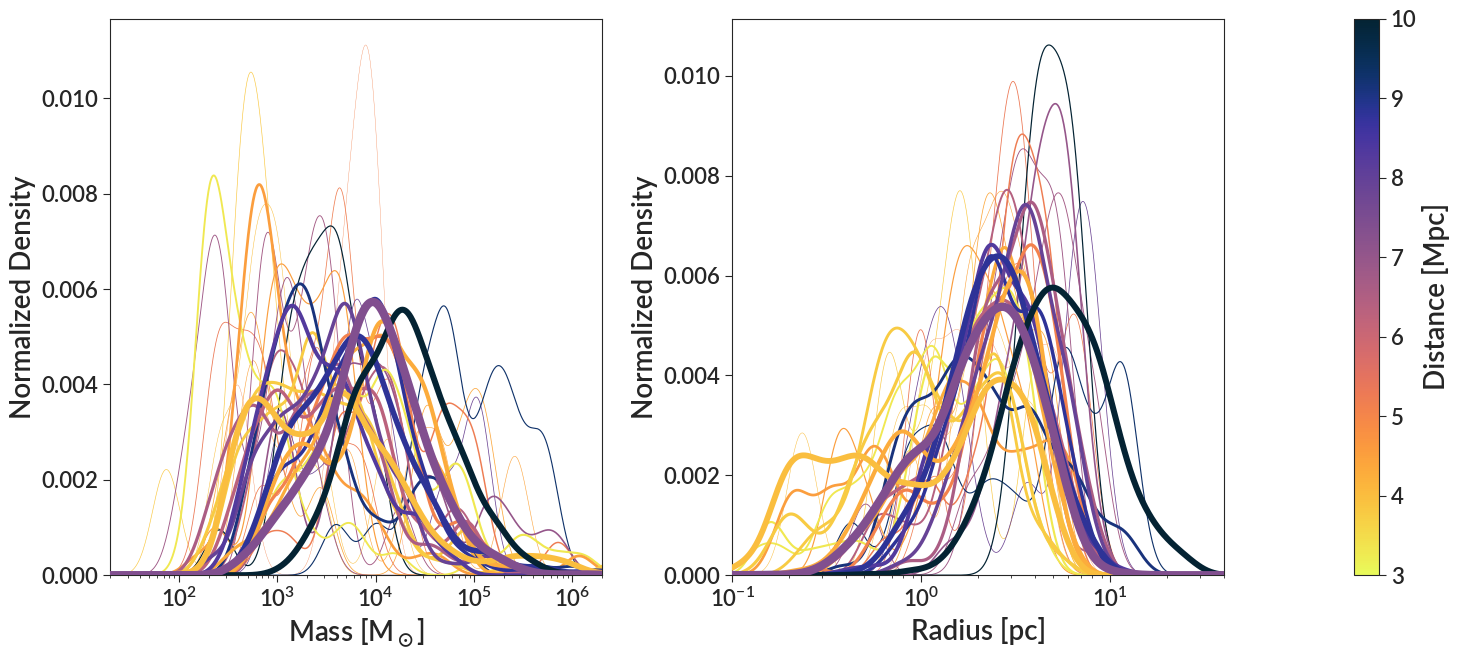

In [7]:
fig, axs = bpl.subplots(ncols=3, gridspec_kw={"width_ratios":[20, 20, 1]},
                        figsize=[15, 7])
mass_bin_edges = np.logspace(1, 8, 1001)
mass_bin_centers = [10**(0.5*(np.log10(mass_bin_edges[i]) + np.log10(mass_bin_edges[i+1])))
                    for i in range(len(mass_bin_edges) - 1)]

r_bin_edges = np.logspace(-2, 2, 1001)
r_bin_centers = [10**(0.5*(np.log10(r_bin_edges[i]) + np.log10(r_bin_edges[i+1])))
                 for i in range(len(r_bin_edges) - 1)]

for cat in catalogs:
    color = mappable.to_rgba(cat["distance"][0])
    
    mass_smooth_hist = create_smooth_hist(cat["mass_msun"], mass_bin_edges, 20)
    axs[0].plot(mass_bin_centers, mass_smooth_hist, lw=0.5 * np.log10(len(cat))**2, color=color, zorder=np.log10(len(cat)))
    
    r_smooth_hist = create_smooth_hist(cat["r_eff_pc_rmax_15pix_best"], r_bin_edges, 20)
    axs[1].plot(r_bin_centers, r_smooth_hist, lw=0.5 * np.log10(len(cat))**2, color=color, zorder=np.log10(len(cat)))
#     ax.hist(cat["mass_msun"], bins=bins, histtype="step", color=color, rel_freq=True)

for ax in axs[:2]:
    ax.set_xscale("log")

axs[0].add_labels("Mass [M$_\odot$]", "Normalized Density")
axs[1].add_labels("Radius [pc]", "Normalized Density")

axs[0].set_limits(20, 2e6, 0)
axs[1].set_limits(0.1, 40, 0)
    
cb = fig.colorbar(mappable, cax=axs[2])
cb.set_label("Distance [Mpc]")

fig.savefig("selection_effects_mass_radius.png")

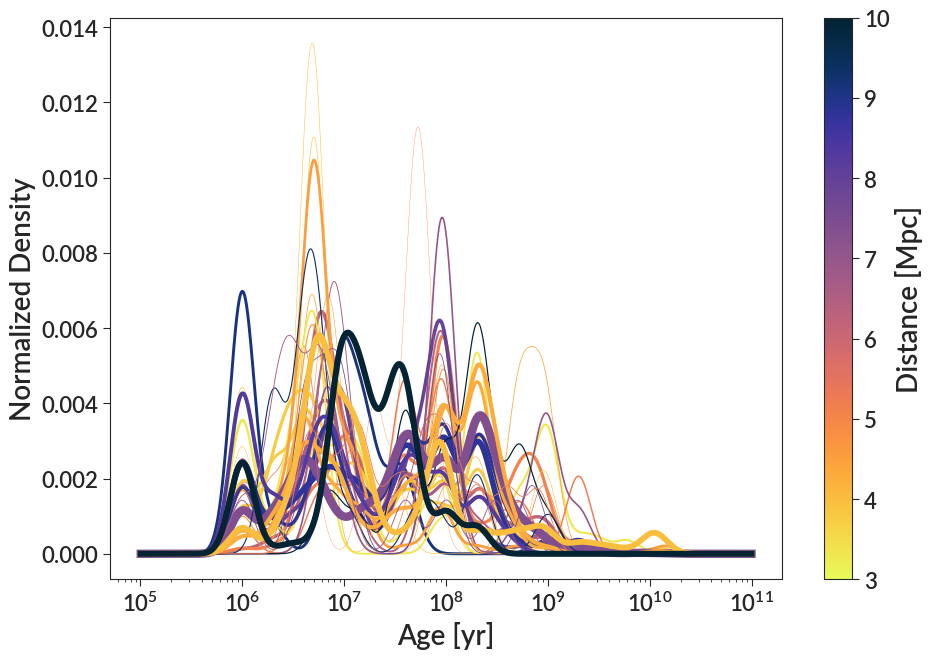

In [8]:
fig, ax = bpl.subplots()
bin_edges = np.logspace(5, 11, 1001)
bin_centers = [10**(0.5*(np.log10(bin_edges[i]) + np.log10(bin_edges[i+1])))
               for i in range(len(bin_edges) - 1)]

for cat in catalogs:
    color = mappable.to_rgba(cat["distance"][0])
    hist, _ = np.histogram(cat["age_yr"], bins=bin_edges)
    
    # then smooth
    kernel = convolution.Gaussian1DKernel(stddev=20)
    smooth_hist = convolution.convolve(hist, kernel)
    
    smooth_hist /= np.sum(smooth_hist)
    
    ax.plot(bin_centers, smooth_hist, lw=0.5 * np.log10(len(cat))**2, color=color)
    
    
#     ax.hist(cat["mass_msun"], bins=bins, histtype="step", color=color, rel_freq=True)
ax.set_xscale("log")
cb = fig.colorbar(mappable, ax=ax)
cb.set_label("Distance [Mpc]")
ax.add_labels("Age [yr]", "Normalized Density")

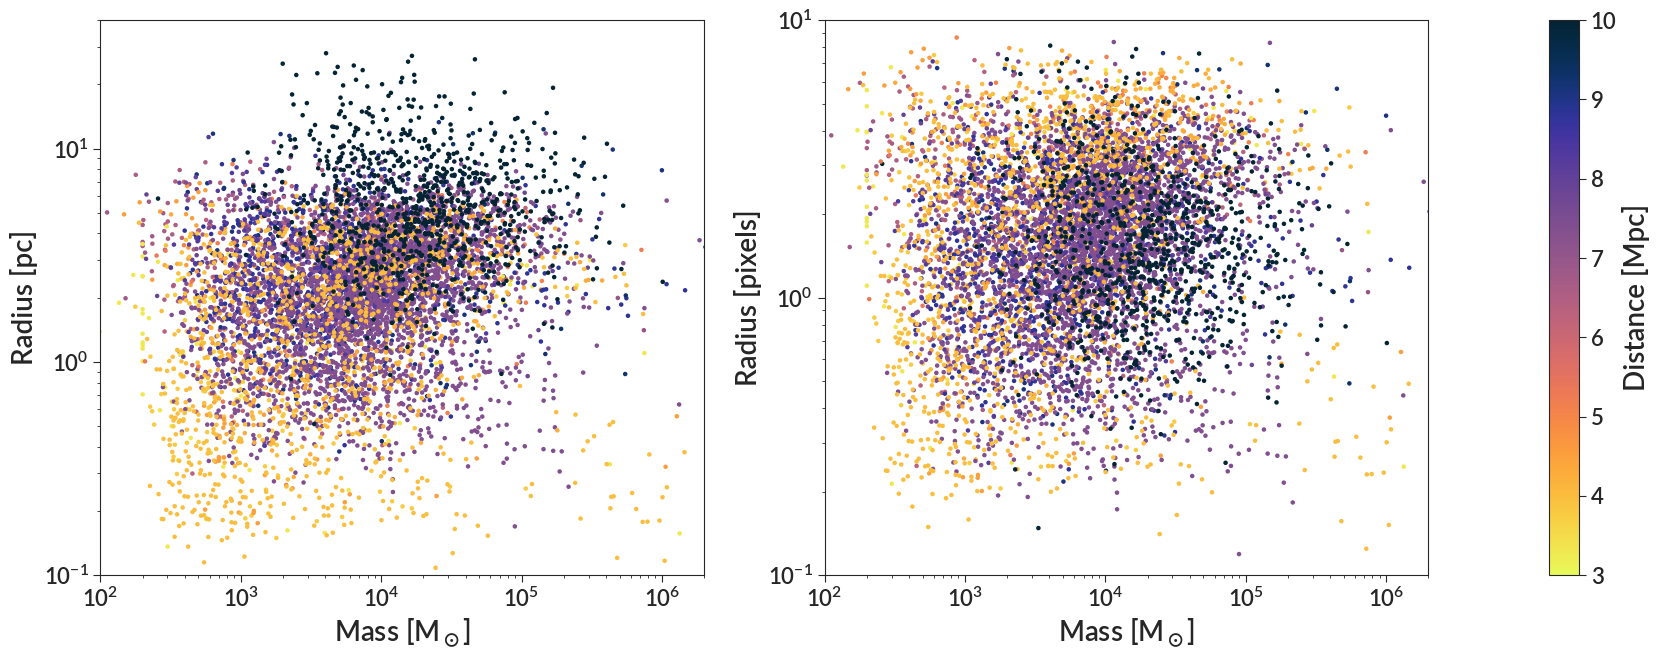

In [9]:
fig, axs = bpl.subplots(ncols=3, gridspec_kw={"width_ratios":[20, 20, 1]},
                        figsize=[17, 7])
plot_colors = mappable.to_rgba(big_catalog["distance"])

axs[0].scatter(big_catalog["mass_msun"], big_catalog["r_eff_pc_rmax_15pix_best"],
               c=plot_colors, s=5, alpha=1)
axs[1].scatter(big_catalog["mass_msun"], big_catalog["r_eff_pixels_rmax_15pix_best"],
               c=plot_colors, s=5, alpha=1)
for ax in axs[:2]:
    ax.set_xscale("log")
    ax.set_yscale("log")

axs[0].add_labels("Mass [M$_\odot$]", "Radius [pc]")
axs[1].add_labels("Mass [M$_\odot$]", "Radius [pixels]")
axs[0].set_limits(100, 2e6, 0.1, 40)
axs[1].set_limits(100, 2e6, 0.1, 10)

cb = fig.colorbar(mappable, cax=axs[2])
cb.set_label("Distance [Mpc]")
fig.savefig("mass_radius_distance.png")